__This notebooks replicates the [Linear Mixed Effects Models tutorial from Edward](http://edwardlib.org/tutorials/linear-mixed-effects-models).__

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.distributions import constraints

from functools import partial

import pyro
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.distributions import Normal, Delta
from pyro.infer import SVI, Trace_ELBO, TracePredictive, EmpiricalMarginal
from pyro.infer.mcmc import MCMC, NUTS
from pyro.optim import Adam, ClippedAdam

from observations import insteval

In [2]:
%matplotlib inline

# Load Data

In [3]:
data, metadata = insteval('./data')
data = pd.DataFrame(data, columns=metadata['columns'])

# s - students - 1:2972
# d - instructors - codes that need to be remapped
# dept also needs to be remapped
data['s'] = data['s'] - 1
data['dcodes'] = data['d'].astype('category').cat.codes
data['deptcodes'] = data['dept'].astype('category').cat.codes
data['y'] = data['y'].values.astype(float)

train = data.sample(frac=0.8)
test = data.drop(train.index)

In [4]:
train.head()

,s,d,studage,lectage,service,dept,y,dcodes,deptcodes
61681,2498,140,6,1,0,10,3.0,74,9
10112,382,363,2,2,0,6,3.0,187,5
30894,1257,13,4,1,0,10,5.0,5,9
37931,1543,1003,6,3,0,10,4.0,525,9
34717,1409,524,8,3,0,4,1.0,271,3


In [10]:
# download from https://nbviewer.jupyter.org/github/blei-lab/edward/tree/master/notebooks/data/
student_effects_lme4 = pd.read_csv('data/insteval_student_ranefs_r.csv', index_col=0)
instructor_effects_lme4 = pd.read_csv('data/insteval_instructor_ranefs_r.csv', index_col=0)
dept_effects_lme4 = pd.read_csv('data/insteval_dept_ranefs_r.csv', index_col=0)

In [9]:
X = torch.Tensor(train[['service', 's', 'dcodes', 'deptcodes']].values)
y = torch.Tensor(train['y'].values)

# Create Model

The model we're interested in is given by:<br>
$y = X\beta + Z\eta + \epsilon$,
$X$ (fixed effects) contains `service` and $Z$ (random effects) contains students `s`, instructors `d` and departments `dept`.<br>
More precisely, the tutorial gives the formula for the following random intercept model in the [`lme4`](http://lme4.r-forge.r-project.org/) Syntax:
`y ~ 1 + (1|students) + (1|instructor) + (1|dept) + service`.

In [5]:
def model(X, y, n_s, n_d, n_dept):
    l = X.shape[0]
    # set up fixed effects
    mu = pyro.param('mu', torch.zeros(1))
    service = pyro.param('service', torch.zeros(1))
    
    sigma_s = pyro.param('sigma_s', torch.ones(1), constraint=constraints.positive)
    sigma_d = pyro.param('sigma_d', torch.ones(1), constraint=constraints.positive)
    sigma_dept = pyro.param('sigma_dept', torch.ones(1), constraint=constraints.positive)

    # set up random effects
    eta_s = pyro.sample('eta_s', Normal(torch.zeros(n_s), torch.ones(n_s)*sigma_s))
    eta_d = pyro.sample('eta_d', Normal(torch.zeros(n_d), torch.ones(n_d)*sigma_d))
    eta_dept = pyro.sample('eta_dept', Normal(torch.zeros(n_dept), torch.ones(n_dept)*sigma_dept))

    yhat = torch.gather(eta_s, 0, X[:,1].long()) + torch.gather(eta_d, 0, X[:,2].long()) +\
        torch.gather(eta_dept, 0, X[:,3].long()) + mu + service * X[:,0]

    with pyro.plate('data_map', l):
        pyro.sample('obs', Normal(yhat, torch.ones(l)), obs=y)
        return yhat

def guide(X, y, n_s, n_d, n_dept):
    mean = {}
    var = {}
    sample = {}
    for t, n in zip(['s', 'd', 'dept'], [n_s, n_d, n_dept]):
        mean[f'eta_{t}'] = pyro.param(f'mean_eta_{t}', torch.zeros(n))
        var[f'eta_{t}'] = pyro.param(f'var_eta_{t}', torch.ones(n), constraint=constraints.positive)
        sample[f'eta_{t}'] = pyro.sample(f'eta_{t}', Normal(mean[f'eta_{t}'], var[f'eta_{t}']))
    return sample

In [6]:
param_store = pyro.get_param_store()

# Train using SVI

In [13]:
loss = []

In [14]:
param_store.clear()

CPU times: user 10.2 s, sys: 491 ms, total: 10.7 s
Wall time: 12.8 s


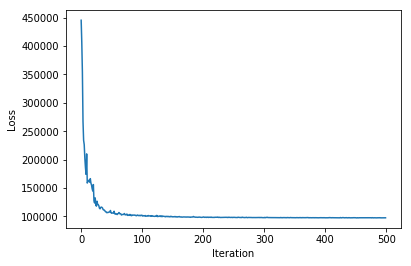

In [15]:
%%time
optimizer = Adam({"lr": 1.0e-1})

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_train = 500
loss += [svi.step(X, y, train['s'].max()+1, train['dcodes'].max()+1, train['deptcodes'].max()+1) for i in np.arange(n_train)]

ax = pd.Series(loss).plot()
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss');

# Compare learned parameters with `lme4`

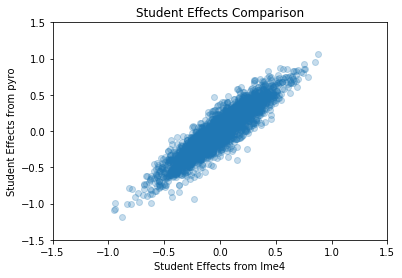

In [16]:
plt.title("Student Effects Comparison")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Student Effects from lme4")
plt.ylabel("Student Effects from pyro")
plt.scatter(student_effects_lme4["(Intercept)"],
            param_store.get_param('mean_eta_s').data.numpy(),
            alpha=0.25)
plt.show()

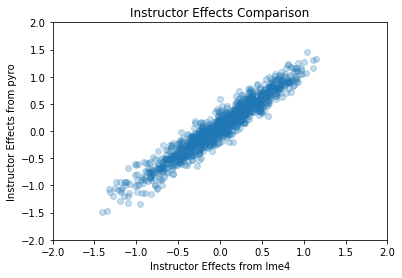

In [17]:
plt.title("Instructor Effects Comparison")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("Instructor Effects from lme4")
plt.ylabel("Instructor Effects from pyro")
plt.scatter(instructor_effects_lme4["(Intercept)"],
            param_store.get_param('mean_eta_d').data.numpy(),
            alpha=0.25)
plt.show()

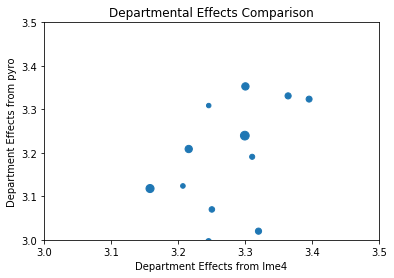

In [18]:
#  Add in the intercept from R and edward
dept_effects_and_intercept_lme4 = 3.28259 + dept_effects_lme4["(Intercept)"]
dept_effects_and_intercept_pyro = param_store.get_param('mu').data.numpy() + param_store.get_param('mean_eta_dept').data.numpy()

plt.title("Departmental Effects Comparison")
plt.xlim(3, 3.5)
plt.ylim(3, 3.5)
plt.xlabel("Department Effects from lme4")
plt.ylabel("Department Effects from pyro")
plt.scatter(dept_effects_and_intercept_lme4,
            dept_effects_and_intercept_pyro,
            s=0.01 * train.dept.value_counts())
plt.show()

# Train using HMC (NUTS)

In [19]:
param_store.clear()

In [36]:
%%time
nuts_kernel = NUTS(model, adapt_step_size=True)
# note that the progress bar from tqdm might need additional setup in jupyter
# optionally set disable_progbar=True
hmc_posterior = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, disable_progbar=False)\
    .run(X, y, train['s'].max()+1, train['dcodes'].max()+1, train['deptcodes'].max()+1)


CPU times: user 35min 48s, sys: 1min 10s, total: 36min 59s
Wall time: 47min 24s


In [37]:
means = {}
for site in ['eta_s', 'eta_d', 'eta_dept']:
    marginal = EmpiricalMarginal(hmc_posterior, [site])._get_samples_and_weights()[0].detach().cpu().numpy()
    means[site] = pd.DataFrame(marginal[:,0]).mean(axis=0)

In [38]:
np.save('data/hmc_means_linear_mixed_effects_model.npy', means) 

In [42]:
means = np.load('data/hmc_means_linear_mixed_effects_model.npy').item()

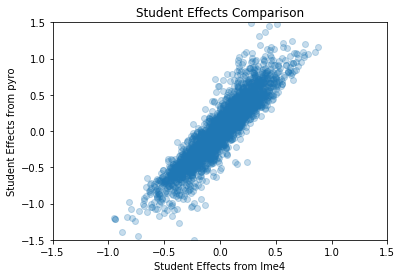

In [43]:
plt.title("Student Effects Comparison")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Student Effects from lme4")
plt.ylabel("Student Effects from pyro")
plt.scatter(student_effects_lme4["(Intercept)"],
            means['eta_s'],
            alpha=0.25)
plt.show()

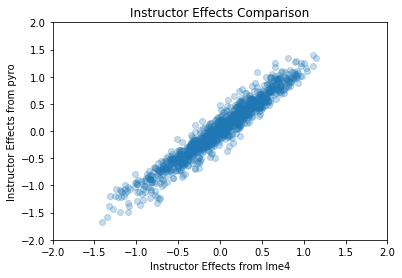

In [40]:
plt.title("Instructor Effects Comparison")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("Instructor Effects from lme4")
plt.ylabel("Instructor Effects from pyro")
plt.scatter(instructor_effects_lme4["(Intercept)"],
            means['eta_d'],
            alpha=0.25)
plt.show()

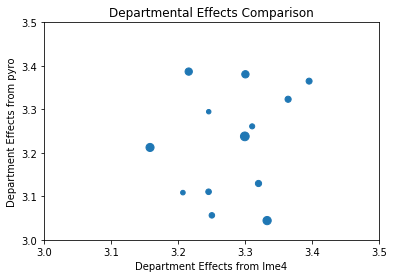

In [41]:
#  Add in the intercept from R and edward
dept_effects_and_intercept_lme4 = 3.28259 + dept_effects_lme4["(Intercept)"]
dept_effects_and_intercept_pyro = param_store.get_param('mu').data.numpy() + means['eta_dept']

plt.title("Departmental Effects Comparison")
plt.xlim(3, 3.5)
plt.ylim(3, 3.5)
plt.xlabel("Department Effects from lme4")
plt.ylabel("Department Effects from pyro")
plt.scatter(dept_effects_and_intercept_lme4,
            dept_effects_and_intercept_pyro,
            s=0.01 * train.dept.value_counts())
plt.show()